In [11]:
%%capture
import sys
import glob, os
import pyicon as pyic
import smt_modules.all_funcs as eva
from smt_modules.icon_smt_levels import dzw, dzt, depthc, depthi

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import gsw

from scipy import stats    #Used for 2D binned statistics
from importlib import reload
import matplotlib.patches as patches

In [2]:
#Reload modules:
reload(eva)

Load my smt functions


<module 'smt_modules.all_funcs' from '/home/m/m300878/submesoscaletelescope/smt_modules/all_funcs.py'>

### local functions

In [3]:
def calc_log10(x_data, y_data):
    mask = ~np.isnan(x_data) & ~np.isnan(y_data) #remove nans from original data
    x_data = x_data[mask]
    y_data = y_data[mask]

    mask = np.ma.masked_where((x_data >= 0), x_data) # remove zeros and negative numbers from xdata
    x_data = x_data[mask.mask]
    y_data = y_data[mask.mask]

    logx = np.log10(np.abs(x_data)) #not nessecary
    logy = np.log10(np.abs(y_data))
    mask = ~np.isnan(logx) & ~np.isnan(logy) & ~np.isinf(logy) #remove inf numbers and nans again after taking log
    logx = logx[mask]
    logy = logy[mask]
    return(logx,logy)

In [133]:
def plot_slope(logx, logy, figname):
    fig, ax = plt.subplots(figsize = (10, 5))
    plt.plot(logx, logy , 'ro', markersize=0.5)

    powerlaw = lambda x, amp, index: amp * (x**index)
    res = stats.linregress(logx, logy)
    plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

    ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
    ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3 \alpha^2) $', fontsize=30)
    ax.set_title(f'{figname}')
    #ax.set_ylim(-6,4) #rectangles
    #ax.set_ylim(-2,2) #rectangles

    plt.legend(title=f'intercept = {res.intercept:.1}')

    #plt.savefig(f'/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/time_dependence/time_space/slope_{figname}.png', dpi=150, format='png', bbox_inches='tight')
#
    res

### select region and time

In [23]:
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'
fpath_ckdtree_1 = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.10_180W-180E_90S-90N.nc'

fpath_ckdtree_3 = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.30_180W-180E_90S-90N.nc'
lon_reg_large = [-72.5, -55]
lat_reg_large = [32, 42]
# asp_large = (lat_reg_large[1]-lat_reg_large[0])/(lon_reg_large[1]-lon_reg_large[0])

# lon_reg = [-65, -60]
# lat_reg = [38.75, 41.25]
#lon_reg = [-65, -60]
#lat_reg = [33, 35.5]
calcname = 'small_33_34'


lon_reg = lon_reg_large
lat_reg = lat_reg_large

#on_reg = [-65, -60]
#lat_reg = [32, 34.5]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])

idepth = 5
itime = 42
tt=1


## load and interpolate data

In [57]:
time_averaged = ''
#time_averaged = '_d_mean'

path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/t{time_averaged}.nc'
t_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/s{time_averaged}.nc'
s_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))
data_t_mean  = pyic.interp_to_rectgrid_xr(t_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_s_mean  = pyic.interp_to_rectgrid_xr(s_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_rho_mean = gsw.rho(data_s_mean.S001_sp, data_t_mean.T001_sp, depthc[2])
mld, mask, mldx = eva.calc_mld_montegut_xr(data_rho_mean, depthc)
mld_mask = mask.transpose('depthc', 'lat', 'lon')
mld_mask = mld_mask.rename(depthc='depthi')
f = eva.calc_coriolis_parameter(data_rho_mean.lat)

path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/bx{time_averaged}.nc'
dbdx_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/by{time_averaged}.nc'
dbdy_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/n2{time_averaged}.nc'
n_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))

data_dbdx_mean   = pyic.interp_to_rectgrid_xr(dbdx_mean.dbdx, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_dbdy_mean   = pyic.interp_to_rectgrid_xr(dbdy_mean.dbdy, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_n2_mean     = pyic.interp_to_rectgrid_xr(n_mean.N2, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

data_M2_mean = np.sqrt(np.power(data_dbdx_mean,2) + np.power(data_dbdy_mean,2))
lat_mean = int((data_n2_mean.lat[-1] - data_n2_mean.lat[0]) /2 + data_n2_mean.lat[0])
ri_mean = eva.calc_richardsonnumber(lat_mean, data_n2_mean, data_M2_mean)

M2_mld = data_M2_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
M2_mld = M2_mld.where(M2_mld !=0)
M2_mld_mean = M2_mld.mean(dim='depthi', skipna=True)

ri_mean_select = ri_mean.sel(depthi=slice(depthi[0], depthi[111])) #ri_mean[:112]
ri_mld = ri_mean_select * mld_mask.data #Todo. check if error to big
ri_mld = ri_mld.where(ri_mld != 0)
ri_mld_mean = ri_mld.mean(dim='depthi', skipna=True)

path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb{time_averaged}_prime.nc'
wb_prime_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
wb_prime_mean = wb_prime_mean.rename(__xarray_dataarray_variable__='wb_prime_mean')
data_wb_prime_mean  = pyic.interp_to_rectgrid_xr(wb_prime_mean.wb_prime_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg) #week
wb_mld = data_wb_prime_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
wb_mld = wb_mld.where(wb_mld != 0) #neglect zeros in average
wb_mld_mean = wb_mld.mean(dim='depthi', skipna=True)

alpha = M2_mld_mean / np.power(f,2)
lhs = wb_mld_mean / np.power(mld,2) / np.power(f,3) / np.power(alpha,2)


In [52]:
tt=0
time_averaged = '_d_mean'

path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/t{time_averaged}.nc'
t_mean = xr.open_dataset(path_data, chunks=dict(depthc=1, time=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/s{time_averaged}.nc'
s_mean = xr.open_dataset(path_data, chunks=dict(depthc=1, time=1))
data_t_mean  = pyic.interp_to_rectgrid_xr(t_mean.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_s_mean  = pyic.interp_to_rectgrid_xr(s_mean.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_rho_mean = gsw.rho(data_s_mean.S001_sp, data_t_mean.T001_sp, depthc[2])
mld, mask, mldx = eva.calc_mld_montegut_xr(data_rho_mean, depthc)
mld_mask = mask.transpose('depthc', 'lat', 'lon')
mld_mask = mld_mask.rename(depthc='depthi')
f = eva.calc_coriolis_parameter(data_rho_mean.lat)

path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/bx{time_averaged}.nc'
dbdx_mean = xr.open_dataset(path_data, chunks=dict(depthi=1, time=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/by{time_averaged}.nc'
dbdy_mean = xr.open_dataset(path_data, chunks=dict(depthi=1, time=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/n2{time_averaged}.nc'
n_mean = xr.open_dataset(path_data, chunks=dict(depthi=1, time=1))

data_dbdx_mean   = pyic.interp_to_rectgrid_xr(dbdx_mean.dbdx.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_dbdy_mean   = pyic.interp_to_rectgrid_xr(dbdy_mean.dbdy.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_n2_mean     = pyic.interp_to_rectgrid_xr(n_mean.N2.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

data_M2_mean = np.sqrt(np.power(data_dbdx_mean,2) + np.power(data_dbdy_mean,2))
lat_mean = int((data_n2_mean.lat[-1] - data_n2_mean.lat[0]) /2 + data_n2_mean.lat[0])
ri_mean = eva.calc_richardsonnumber(lat_mean, data_n2_mean, data_M2_mean)

M2_mld = data_M2_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
M2_mld = M2_mld.where(M2_mld !=0)
M2_mld_mean = M2_mld.mean(dim='depthi', skipna=True)

ri_mean_select = ri_mean.sel(depthi=slice(depthi[0], depthi[111])) #ri_mean[:112]
ri_mld = ri_mean_select * mld_mask.data #Todo. check if error to big
ri_mld = ri_mld.where(ri_mld != 0)
ri_mld_mean = ri_mld.mean(dim='depthi', skipna=True)

path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb{time_averaged}_prime.nc'
wb_prime_mean = xr.open_dataset(path_data, chunks=dict(depthi=1, time=1))
wb_prime_mean = wb_prime_mean.rename(__xarray_dataarray_variable__='wb_prime_mean')
data_wb_prime_mean  = pyic.interp_to_rectgrid_xr(wb_prime_mean.wb_prime_mean.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg) #week
wb_mld = data_wb_prime_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
wb_mld = wb_mld.where(wb_mld != 0) #neglect zeros in average
wb_mld_mean = wb_mld.mean(dim='depthi', skipna=True)

alpha = M2_mld_mean / np.power(f,2)
lhs = wb_mld_mean / np.power(mldx,2) / np.power(f,3) / np.power(alpha,2)


dividig by alpha eliminates lateral density fronts in data

In [227]:
alpha = M2_mld_mean / np.power(f,2)
lhsx = wb_mld_mean / np.power(f,3) / np.power(mldx,2) / np.power(alpha,2) 


In [230]:
psi = - wb_mld_mean / M2_mld_mean
lhs_psi = psi / np.power(mldx,2) / np.power(f,1) / np.power(alpha,1) 

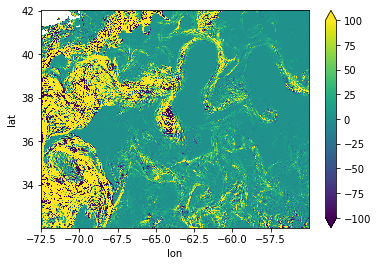

In [172]:
lhsx.plot(vmin=-1e2, vmax=1e2)

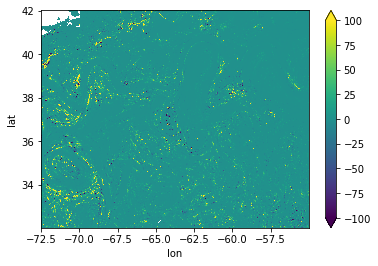

In [190]:
lhsx.plot(vmin=-1e2, vmax=1e2)

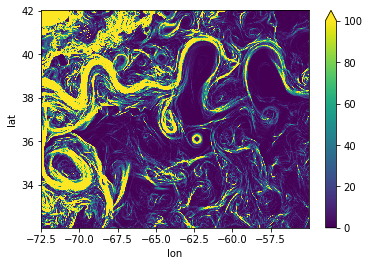

In [183]:
np.power(alpha,2).plot(vmin=0, vmax=1e2)

In [31]:
lon_reg_R1 = [-65, -60]
lat_reg_R1 = [32, 34.5]
lon_reg_R2 = [-65, -60]
lat_reg_R2 = [38.75, 41.25]
lon_reg_R3 = [-65, -60]
lat_reg_R3 = [35.375, 37.875]
lon_reg_R4 = [-68, -65.2]
lat_reg_R4 = [35, 37]
#fronts
lon_f1 = -61.25
lat_f1 =  32.5, 33.5

lon_f2 = -59.39
lat_f2 =  35.3, 36.1

lon_f3 = -62.35
lat_f3 =  35.45, 36.15

lon_f4 = -66.1
lat_f4 =  34.1, 34.75

In [7]:
def draw_rect(lat, lon, color):
    height = lat[1] - lat[0]
    width = lon[1] - lon[0]
    right = lon[0] + width
    top = lat[0] + height
    rect = patches.Rectangle((lon[0], lat[0]), width, height, linewidth=3, edgecolor=color, facecolor='none')
    return  rect, right, top

def add_rect():
    #boxes
    lon_reg_R1 = [-65, -60]
    lat_reg_R1 = [32, 34.5]
    lon_reg_R2 = [-65, -60]
    lat_reg_R2 = [38.75, 41.25]
    lon_reg_R3 = [-65, -60]
    lat_reg_R3 = [35.375, 37.875]
    lon_reg_R4 = [-68, -65.2]
    lat_reg_R4 = [35, 37]
    #fronts
    lon_f1 = -61.25
    lat_f1 =  32.5, 33.5
    
    lon_f2 = -59.39
    lat_f2 =  35.3, 36.1
    
    lon_f3 = -62.35
    lat_f3 =  35.45, 36.15
    
    lon_f4 = -66.1
    lat_f4 =  34.1, 34.75
    fs=25

    ax.vlines(lon_f1, lat_f1[0], lat_f1[1], color='g', linewidth=3)
    ax.text(lon_f1, lat_f1[1], f'F1', fontsize=fs)

    ax.vlines(lon_f2, lat_f2[0], lat_f2[1], color='g', linewidth=3)
    ax.text(lon_f2, lat_f2[1], f'F2', fontsize=fs)

    ax.vlines(lon_f3, lat_f3[0], lat_f3[1], color='g', linewidth=3)
    ax.text(lon_f3, lat_f3[1], f'F3', fontsize=fs)

    ax.vlines(lon_f4, lat_f4[0], lat_f4[1], color='g', linewidth=3)
    ax.text(lon_f4, lat_f4[0], f'F4', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R1, lon_reg_R1,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R1', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R2, lon_reg_R2,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R2', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R3, lon_reg_R3,  color='black')
    ax.add_patch(rect)
    ax.text(right, top, f'R3', fontsize=fs)

    rect, right, top = draw_rect(lat_reg_R4, lon_reg_R4,  color='black')
    ax.add_patch(rect)
    ax.text(right-1.7, top, f'R4', fontsize=fs)

## interpolation

In [9]:
M2_test = data_M2_mean.isel(depthi=5)

In [24]:
grid03 = xr.open_dataset(fpath_ckdtree_3)
grid01 = xr.open_dataset(fpath_ckdtree_1)

In [25]:
grid03_sel = grid03.sel(lon=slice(-72.5, -55), lat=slice(32, 42))
grid01_sel = grid01.sel(lon=slice(-72.5, -55), lat=slice(32, 42))

In [26]:
M2_test_inter3 = M2_test.interp_like(grid03_sel, method='linear', assume_sorted=False, kwargs=None)
M2_test_inter1 = M2_test.interp_like(grid01_sel, method='linear', assume_sorted=False, kwargs=None)

interpolate lhs and ri_mld 

In [58]:
lhs_inter = lhs.interp_like(grid03_sel, method='linear', assume_sorted=False, kwargs=None)
ri_mld_mean_inter = ri_mld_mean.interp_like(grid03_sel, method='linear', assume_sorted=False, kwargs=None)

In [231]:
lhs_inter = lhs_psi.interp_like(grid01_sel, method='linear', assume_sorted=False, kwargs=None)
ri_mld_mean_inter = ri_mld_mean.interp_like(grid01_sel, method='linear', assume_sorted=False, kwargs=None)

# visual

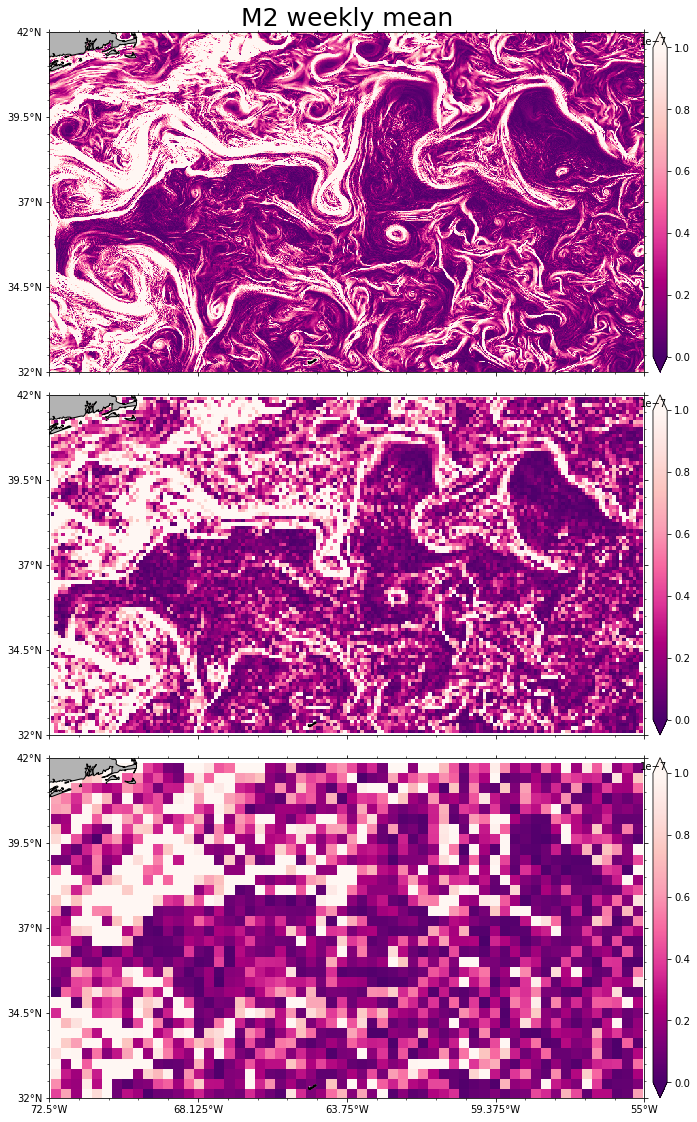

In [28]:
hca, hcb = pyic.arrange_axes(1, 3, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
lon_reg1 = data_M2_mean.lon
lat_reg1 = data_M2_mean.lat

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim=0,1e-7
pyic.shade(lon_reg1, lat_reg1, M2_test, ax=ax, cax=cax,  transform=ccrs_proj, clim=clim, rasterized=False, cmap='RdPu_r')
ax.set_title('M2 weekly mean', fontsize=25)
ii+=1; ax=hca[ii]; cax=hcb[ii]
lon_reg1 = M2_test_inter1.lon
lat_reg1 = M2_test_inter1.lat
pyic.shade(lon_reg1, lat_reg1, M2_test_inter1, ax=ax, cax=cax,  transform=ccrs_proj, clim=clim, rasterized=False, cmap='RdPu_r')
ii+=1; ax=hca[ii]; cax=hcb[ii]
lon_reg1 = M2_test_inter3.lon
lat_reg1 = M2_test_inter3.lat
pyic.shade(lon_reg1, lat_reg1, M2_test_inter3, ax=ax, cax=cax,  transform=ccrs_proj, clim=clim, rasterized=False, cmap='RdPu_r')




for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) # , xlim=lon_region_large, ylim=lat_region_large

plt.savefig(f'/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/grid_interp.png', dpi=250, format='png', bbox_inches='tight')



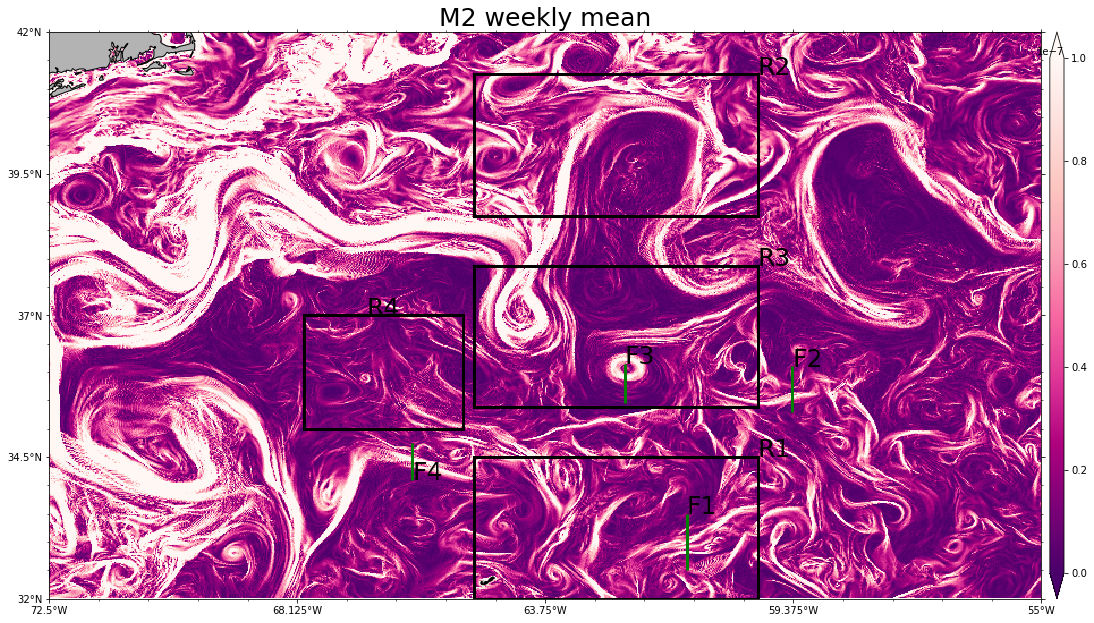

In [171]:
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=5, projection=ccrs_proj, axlab_kw=None)
ii=-1
lon_reg1 = data_M2_mean.lon
lat_reg1 = data_M2_mean.lat

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim=0,1e-7
pyic.shade(lon_reg1, lat_reg1, data_M2_mean.isel(depthi=5), ax=ax, cax=cax,  transform=ccrs_proj, clim=clim, rasterized=False, cmap='RdPu_r')
ax.set_title('M2 weekly mean', fontsize=25)

fs=25

add_rect()

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg) # , xlim=lon_region_large, ylim=lat_region_large

#plt.savefig(f'/home/m/m300878/submesoscaletelescope/notebooks/images/eval_ri/time_dependence/slope_regions.png', dpi=350, format='png', bbox_inches='tight')



# slopes

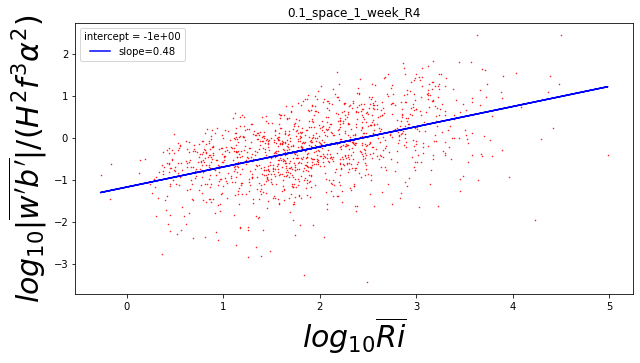

In [232]:
R = 'R4'
lon_reg_select = lon_reg_R2
lat_reg_select = lat_reg_R2

figname = f'0.1_space_1_week_{R}'
ri_mld_mean_sel = ri_mld_mean_inter.sel(lat=slice(lat_reg_select[0],lat_reg_select[1])).sel(lon=slice(lon_reg_select[0],lon_reg_select[1])) 
#ri_mld_mean_sel = ri_mld_mean_sel - ri_mld_mean_sel.mean()
lhs_sel = lhs_inter.sel(lat=slice(lat_reg_select[0],lat_reg_select[1])).sel(lon=slice(lon_reg_select[0],lon_reg_select[1]))
#lhs_sel = lhs_sel -lhs_sel.mean()

laty, lonx = ri_mld_mean_sel.shape
logx, logy = calc_log10(np.reshape(ri_mld_mean_sel.data, laty*lonx), np.reshape(lhs_sel.data, laty*lonx))
plot_slope(logx, logy, figname)

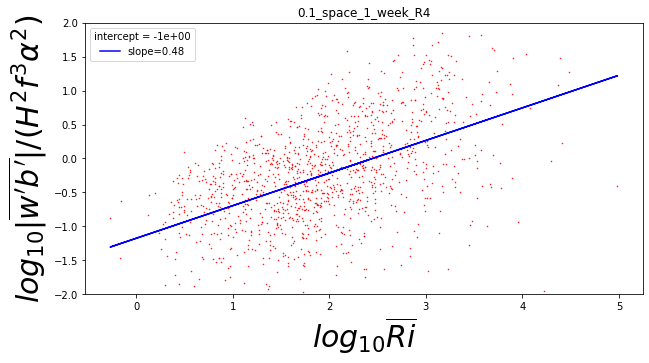

In [94]:
R = 'R4'
lon_reg_select = lon_reg_R2
lat_reg_select = lat_reg_R2

figname = f'0.1_space_1_week_{R}'
ri_mld_mean_sel = ri_mld_mean_inter.sel(lat=slice(lat_reg_select[0],lat_reg_select[1])).sel(lon=slice(lon_reg_select[0],lon_reg_select[1]))
lhs_sel = lhs_inter.sel(lat=slice(lat_reg_select[0],lat_reg_select[1])).sel(lon=slice(lon_reg_select[0],lon_reg_select[1]))

laty, lonx = ri_mld_mean_sel.shape
logx, logy = calc_log10(np.reshape(ri_mld_mean_sel.data, laty*lonx), np.reshape(lhs_sel.data, laty*lonx))
plot_slope(logx, logy, figname)

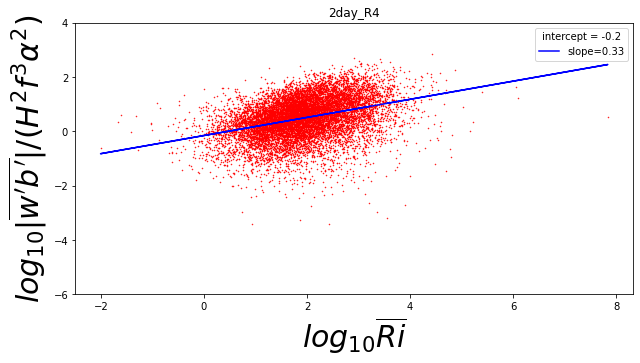

In [165]:
R = 'R4'
lon_reg_select = lon_reg_R4
lat_reg_select = lat_reg_R4

figname = f'2day_{R}'
ri_mld_mean_sel = ri_mld_mean.sel(lat=slice(lat_reg_select[0],lat_reg_select[1])).sel(lon=slice(lon_reg_select[0],lon_reg_select[1]))
lhs_sel = lhs.sel(lat=slice(lat_reg_select[0],lat_reg_select[1])).sel(lon=slice(lon_reg_select[0],lon_reg_select[1]))

laty, lonx = ri_mld_mean_sel.shape
logx, logy = calc_log10(np.reshape(ri_mld_mean_sel.data, laty*lonx), np.reshape(lhs_sel.data, laty*lonx))
plot_slope(logx, logy, figname)

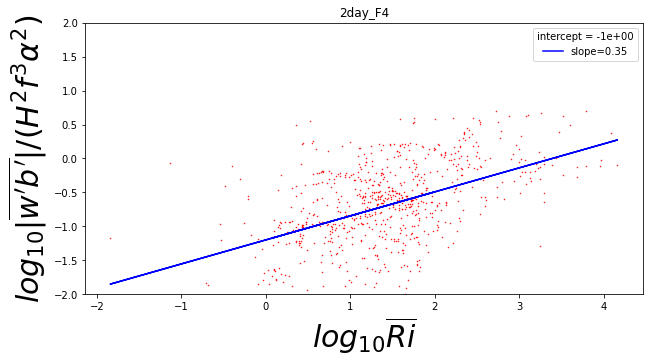

In [170]:
F              = 'F4'
lon_front      = lon_f4
lat_reg_select = lat_f4
figname        = f'2day_{F}'

wb_fselect   = wb_mld.sel(lon=lon_front, method='nearest').sel( lat=slice(lat_reg_select[0], lat_reg_select[1]))#.mean(dim='depthi', skipna=True)
ri_fselect   = ri_mld.sel(lon=lon_front, method='nearest').sel( lat=slice(lat_reg_select[0], lat_reg_select[1]))#.mean(dim='depthi', skipna=True)
mldx_fselect = mldx.sel(lon=lon_front, method='nearest').sel( lat=slice(lat_reg_select[0], lat_reg_select[1]))
m2_fslect    = M2_mld.sel(lon=lon_front, method='nearest').sel( lat=slice(lat_reg_select[0], lat_reg_select[1])).mean(dim='depthi', skipna=True)
alpha        = m2_fslect / np.power(f,2)
lhs_fselect  = wb_fselect / np.power(mldx_fselect,2) / np.power(f,3) / np.power(alpha,2)
logx, logy        = calc_log10(np.reshape(ri_fselect.data, ri_fselect.size), np.reshape(lhs_fselect.data, ri_fselect.size))
plot_slope(logx, logy, figname)